# Creation of my first neural network

## Feed Forward Back Propagation

se creará una red neuronal feed forward back propagation con una capa de entrada, una capa oculta y una capa de salida

retorpropagacion: https://www.youtube.com/watch?v=tIeHLnjs5U8

backpropagation: https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd

### Author

Fabian Castaño [GitHub](https://www.github.com/fabioc9675)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # no usar GPU
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # usar GPU

```
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub Version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")
```

In [2]:
# importacion de librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub Version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")


Version:  2.10.0
Eager mode:  True
Hub Version:  0.12.0
GPU is NOT AVAILABLE


In [3]:
# Carga de los datos de entrenamiento
# d_train = pd.read_csv("dataset/dataset_test.csv")
# d_train.head(5)
# d_train.groupby('rain').describe()

d_train = pd.read_csv("dataset/seeds_dataset.csv")
d_train.head(5)
d_train.groupby('salida').describe()


var_1                                                               \
       count       mean       std    min      25%     50%      75%    max   
salida                                                                      
1       70.0  14.334429  1.215704  11.23  13.7500  14.355  15.0450  17.08   
2       70.0  18.334286  1.439496  15.38  17.3300  18.720  19.1375  21.18   
3       70.0  11.873857  0.723004  10.59  11.2625  11.835  12.4250  13.37   

       var_2             ...    var_6        var_7                             \
       count       mean  ...      75%    max count      mean       std    min   
salida                   ...                                                    
1       70.0  14.294286  ...  3.30100  6.685  70.0  5.087214  0.263699  4.519   
2       70.0  16.135714  ...  4.43600  6.682  70.0  6.020600  0.253934  5.144   
3       70.0  13.247857  ...  5.46725  8.456  70.0  5.116400  0.162068  4.745   

                                        
           25%     50%      75%    max  
salida                                  
1       4.9245  5.0940  5.22350  5.877  
2       5.8775  5.9815  6.18775  6.550  
3       5.0020  5.0915  5.22850  5.491  

[3 rows x 56 columns]

## Normalizacion de dataset


In [4]:
def normDataset(x, val):
    return x/val


In [5]:
# normalizacion
# d_train[['temperature', 'humidity', 'radiation']] = d_train[['temperature', 'humidity', 'radiation']].apply(
#     lambda x: normDataset(x,100))
d_train[['var_1', 'var_2','var_3','var_4','var_5','var_6','var_7']] = d_train[['var_1', 'var_2','var_3','var_4','var_5','var_6','var_7']].apply(
    lambda x: normDataset(x,100))

d_train.head(5)


,var_1,var_2,var_3,var_4,var_5,var_6,var_7,salida
0,0.1663,0.1546,0.008747,0.06053,0.03465,0.02040,0.05877,1
1,0.1644,0.1525,0.008880,0.05884,0.03505,0.01969,0.05533,1
2,0.1526,0.1485,0.008696,0.05714,0.03242,0.04543,0.05314,1
3,0.1403,0.1416,0.008796,0.05438,0.03201,0.01717,0.05001,1
4,0.1389,0.1402,0.008880,0.05439,0.03199,0.03986,0.04738,1


In [6]:
# clean data
dataset = d_train.dropna()

# convert categorical 'Origin' data into one-hot data
origin = dataset.pop('salida')
# origin = dataset.pop('rain')
dataset['pequena'] = (origin == 1)*1
dataset['mediana'] = (origin == 2)*1
dataset['grande'] = (origin == 3)*1

dataset.tail()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,pequena,mediana,grande
205,0.1182,0.1340,0.008274,0.05314,0.02777,0.04471,0.05178,0,0,1
206,0.1121,0.1313,0.008167,0.05279,0.02687,0.06169,0.05275,0,0,1
207,0.1143,0.1313,0.008335,0.05176,0.02719,0.02221,0.05132,0,0,1
208,0.1249,0.1346,0.008658,0.05267,0.02967,0.04421,0.05002,0,0,1
209,0.1270,0.1371,0.008491,0.05386,0.02911,0.03260,0.05316,0,0,1


## Separacion de los datos

agrupar los datos de entrenamiento y de validacion, separar las entradas de las salida y convertir las salidas en un vector de la forma [0,0,0] a paritr del dato


In [7]:
d_train_x = dataset[['var_1', 'var_2','var_3','var_4','var_5','var_6','var_7']].to_numpy()
# d_train_x = dataset[['temperature', 'humidity','radiation']].to_numpy()
d_train_y = dataset[['pequena','mediana','grande']].to_numpy()

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(d_train_x, d_train_y, test_size=0.3)

## Network creation

creation of neural network class


In [8]:
# Using Keras more complex model
# model
modelo = tf.keras.Sequential([
    tf.keras.layers.Dense(units=5, activation='sigmoid', input_shape=[7]), #  Hidden layer of 5 neurons with 3 input
    tf.keras.layers.Dense(units=5, activation='sigmoid'), #  intermediate layer
    tf.keras.layers.Dense(units=3, activation='sigmoid'),
])

print(modelo.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 40        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 88
Trainable params: 88
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
modelo.compile(
    optimizer = tf.keras.optimizers.Adam(0.01),
    loss = 'mean_squared_error'
)

#  modelo.sumary()

In [10]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(modelo, to_file=dot_img_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Model creation and training

Creation of the model to predict seeds distribution

In [11]:
print("Comienza entrenamiento...")
history = modelo.fit(x_train, y_train, epochs = 1000, batch_size=5, verbose = True)
print("Modelo entrenado!")

Comienza entrenamiento...
Epoch 1/1000
30/30 [==============================] - 1s 2ms/step - loss: 0.2455
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.2253
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.2240
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.2225
Epoch 5/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.2234
Epoch 6/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.2221
Epoch 7/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.2239
Epoch 8/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.2237
Epoch 9/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.2221
Epoch 10/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.2239
Epoch 11/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.2224
Epoch 12/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.2221

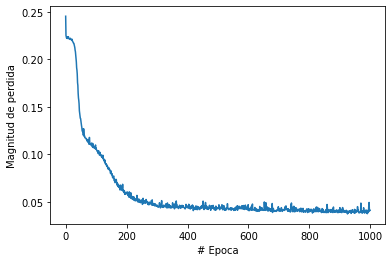

In [12]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(history.history["loss"])

## Validation process

validate the Neural Network working with test data

In [13]:
# Make the prediction on test data and measure performance
print(x_test.shape)
y_pred = modelo.predict(x_test)

y_test_out = np.argmax(y_test, axis=1)
y_pred_out = np.argmax(y_pred, axis=1)
print(f"Accuracy Score: {np.round(accuracy_score(y_test_out, y_pred_out)*100,2)}")

(63, 7)
2/2 [==============================] - 0s 2ms/step
Accuracy Score: 87.3


In [14]:
# print some data test
for i in range(10):
    print(f"predict: {y_pred_out[i]}, target: {y_test_out[i]}")

predict: 0, target: 0
predict: 2, target: 2
predict: 0, target: 0
predict: 0, target: 0
predict: 0, target: 0
predict: 2, target: 2
predict: 2, target: 0
predict: 0, target: 0
predict: 0, target: 0
predict: 0, target: 0


# Prediccion de un dato

este dato debe dar en la tercera neurona

In [15]:
x_val = np.array([12.22,13.32,0.8652,5.224,2.967,5.469,5.221],dtype = float)/100
# x_val = x_test[2]
x_val = x_val.reshape((1,7))
print(x_val.shape)
modelo.predict(x_val)

(1, 7)
1/1 [==============================] - 0s 22ms/step


array([[0.01921491, 0.00198944, 0.98221153]], dtype=float32)